# Calculate metrics for ficture results (in spatialdata object)
calculate percentage of markers outside of cluster

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import spatialdata
from scipy.spatial import KDTree
from scipy.stats import zscore
from tqdm import tqdm

%matplotlib inline

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


ModuleNotFoundError: No module named 'pydeseq2'

In [ ]:
sdata_file = "/Volumes/SSD-SF/P06_cellseg_benchmark/spatialdata-objects/FOXF2/SLIDE2/REGION1/sdata.zarr"
ficture_dex_file = "/Volumes/SSD-SF/P06_MERFISH_Foxf2/alt-segmentations/FICTURE/SLIDE02/r1/nF25.d_6/nF25.d_6.prj_6.r_4_5.factor.info.tsv"

In [ ]:
sdata_file = "/home/hspitzer/projects/cellseg_benchmark/data/processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr"
ficture_dex_file = "/home/hspitzer/projects/cellseg_benchmark/data/ficture_output/r1/analysis/nF25.d_6/nF25.d_6.prj_6.r_4_5.factor.info.tsv"

In [ ]:
slide_name = "slide2"
region_name = "region1"
ficture_name = "nF25_d6"

In [ ]:
sdata = spatialdata.read_zarr(sdata_file)

In [ ]:
sdata

In [ ]:
sdata[f"{slide_name}_{region_name}_nF25_d6_pixel_factors"].head()

In [2]:
sdata[f"{slide_name}_{region_name}_transcripts"].head()

NameError: name 'sdata' is not defined

In [6]:
sdata.table

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_13855/4181403938.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  sdata.table


AnnData object with n_obs × n_vars = 107013 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Fth1_raw', 'Fth1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'App_raw', 'App_high_pass', 'Aldoc_raw', 'Aldoc_high_pass', 'Sst_raw', 'Sst_high_pass', 'Plp1_raw', 'Plp1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'region', 'slide', 'dataset_id', 'cells_region', 'EntityID'
    uns: 'spatialdata_attrs'
    obsm: 'blank', 'spatial'

In [42]:
# cell types from gene panel
cell_types_mouse_brain = {
    "ECs": ["Cldn5", "Cdh5", "Pecam1", "Kdr", "Flt1", "Tie1", "Tek", "Nos3"],
    "Pericytes": ["Vtn", "Kcnj8", "Rgs5", "Cd248", "Atp13a5", "Anpep"],
    "SMCs": ["Acta2", "Pdlim3", "Tagln", "Myh11", "Sncg", "Cnn1", "Pln", "Adamts1"],
    "Fibroblasts": ["Dcn", "Col1a1", "Lama1", "Fn1", "Slc7a11", "Il33", "Slc6a13"],
    "Ependymal cells": ["Ccdc153", "Tmem212", "Pifo", "Foxj1"],
    "Microglia_Macrophages": [
        "Trem2",
        "Cx3cr1",
        "Aif1",
        "Itgam",
        "Itgax",
        "C1qc",
        "Ctss",
        "C1qa",
        "Cx3cr1",
        "Ctss",
        "Cd163",
    ],
    "Oligodendrocytes": [
        "Cnp",
        "Cldn11",
        "Mbp",
        "Mag",
        "Mog",
        "Enpp2",
        "Trf",
        "Apod",
        "Plxnb3",
    ],  # had Plp1 as well, but not in our dataset
    "OPCs": [
        "Ptprz1",
        "Pdgfra",
        "Cspg4",
        "Olig1",
        "Cspg5",
        "Rgcc",
        "Olig2",
        "Vcan",
        "Cd9",
        "Sox10",
        "Apod",
    ],
    "Astrocytes": [
        "Aqp4",
        "Apoe",
        "Clu",
        "Plpp3",
        "Slc1a3",
    ],  # had Aldoc as well, but not in our dataset
    "Neurons": [
        "Meg3",
        "Slc17a7",
        "Ptprd",
        "Gad2",
        "Gad1",
        "Galntl6",
        "Rbfox3",
        "Map2",
        "Slc32a1",
    ],
}

## Check transcript counts for each factor

In [43]:
factor_count = (
    sdata[f"{slide_name}_{region_name}_transcripts"]
    .groupby(f"{ficture_name}_factors")
    .count()
    .compute()["x"]
)

In [44]:
# factor 25 are those transcripts that could not be matched to pixels
print(f"fraction not annotated: {factor_count[25] / factor_count.sum() * 100:.2f}%")

fraction not annotated: 0.13%


Text(0, 0.5, 'count')

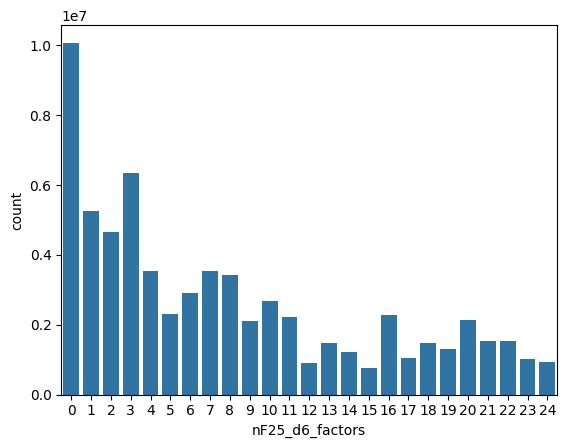

In [45]:
ax = sns.barplot(factor_count[0:25])
ax.axes.set_ylabel("count")

## Get differentially expressed genes for FICTURE results and overlap with marker genes

In [46]:
ficture_dex = pd.read_table(ficture_dex_file)
ficture_dex = ficture_dex.set_index("Factor")

ficture_dex

,RGB,Weight,PostUMI,TopGene_pval,TopGene_fc,TopGene_weight
Factor,,,,,,
0,"242,200,58",0.14342,13852807,"Mbp, Lpar1, Serpina3n, Gatm, Gfap, Wnt2b","Mbp, Lpar1, Serpina3n, Wnt2b, Gatm, Gfap","Mbp, Gatm, Lpar1, Gfap, Serpina3n, S100b, Cnp,..."
3,"69,99,217",0.08849,8546895,"Slc17a7, Dnm1, Prkcg, Rab6a, Slc4a10, Pde1a, C...","Slc17a7, Eln, Prkcg, Lpl, Dnm1, Osr1, Pdgfb, P...","Slc17a7, Dnm1, Rab6a, Prkcg, Cx3cl1, Nefl, Slc..."
1,"253,163,48",0.08124,7846686,"Meg3, Aldh1a2, Fnbp4, Col4a2, Slc38a5, Nbeal1,...","Meg3, Slc38a5, Aldh1a2, Slc22a2, Fxyd5, Tjp3, ...","Meg3, Dnm1, Lrp1, Mapt, Kansl1, Fnbp4, Madd, C..."
2,"243,99,21",0.07491,7235112,"Cnp, Trf, Cldn11, Mag, Enpp2, Gatm, Sox10, Il3...","Cldn11, Hapln2, Mag, Opalin, Trf, Cnp, Sox10, ...","Cnp, Trf, Mbp, Enpp2, Gatm, Cldn11, Mag, Olig1..."
4,"27,229,180",0.05275,5095317,"Plpp3, Gja1, Htra1, Mfge8, Sox9, Vegfa, Slc1a3...","Gja1, Plpp3, Mfge8, Htra1, Sox9, Prdm16, Slc1a...","Plpp3, Gja1, Htra1, Mfge8, Apoe, Sox9, Clu, Aq..."
8,"60,53,139",0.05027,4855345,"Tcf7l2, Plekhg1, AI593442, Ctnnb1, Rorb, Edil3...","Tcf7l2, Plekhg1, Zic3, Pdlim3, Rorb, Pmaip1, P...","Tcf7l2, Dnm1, Plekhg1, Ctnnb1, AI593442, Cltc,..."
7,"50,241,151",0.04741,4579186,"Ncam1, Nos1, Otof, Drd1, Dpp10, Slc7a14, Dnm1,...","Nos1, Otof, Drd1, Cgn, Ncam1, Klf5, Serpine1, ...","Dnm1, Ncam1, Ctnnb1, Cltc, Nos1, Mapt, Rab6a, ..."
6,"199,40,3",0.04422,4271258,"Arpp21, Lamp5, A830036E02Rik, Cx3cl1, AI593442...","Vip, Adora2a, Lamp5, Arpp21, A830036E02Rik, Kr...","Arpp21, Cx3cl1, AI593442, Lamp5, Dnm1, Fscn1, ..."
10,"51,172,246",0.04107,3967217,"Gad1, Gad2, Slc32a1, Pvalb, Dnm1, Dnm3, AI5934...","Gad1, Gad2, Slc32a1, Pvalb, Reln, Spp1, Galntl...","Gad1, Dnm1, Gad2, Slc32a1, Cltc, AI593442, Rab..."


<Axes: >

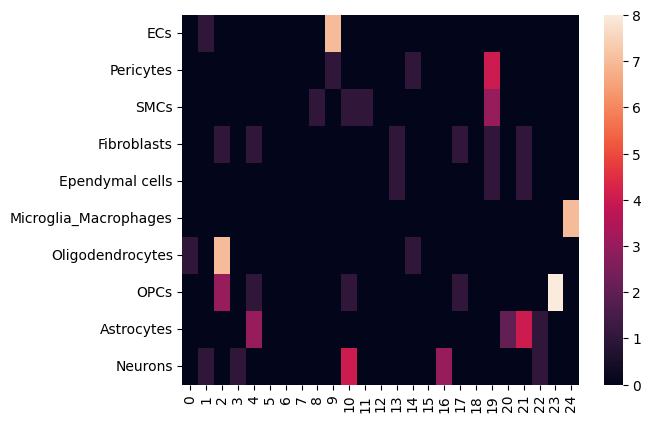

In [47]:
# calculate overlap between ficture dex genes and marker genes
overlap = pd.DataFrame(
    index=range(25), columns=cell_types_mouse_brain.keys(), dtype=int
)
for factor in range(25):
    genes = ficture_dex["TopGene_fc"][factor].split(", ")
    for ct, ct_genes in cell_types_mouse_brain.items():
        overlap[ct][factor] = len(set(ct_genes).intersection(genes))

sns.heatmap(overlap.T)

In [38]:
# get color code for factors
factor_color_code = ficture_dex["RGB"]

## Ratio of mean marker gene expression within cluster / without cluster

In [50]:
# get pixel size of factors for normalisation
factor_size = (
    sdata[f"{slide_name}_{region_name}_{ficture_name}_pixel_factors"]
    .groupby("K1")
    .count()
    .compute()["x"]
)

# calculate #transcripts per gene x factor
gene_factor_count = (
    sdata[f"{slide_name}_{region_name}_transcripts"]
    .groupby(["gene", f"{ficture_name}_factors"])
    .count()
    .compute()
)
factor_counts_df = gene_factor_count["x"].unstack()
# normalise by pixel size of factors
norm_factor_counts_df = factor_counts_df / factor_size

In [55]:
factor_counts_df.T

gene,A830036E02Rik,AI593442,Abca1,Abcb1a,Abcb1b,Abcc9,Abcg2,Acan,Ace2,Acer2,...,Vtn,Vwf,Wbp2,Wdr12,Wnt2b,Wnt7a,Xirp1,Zcchc14,Zeb1,Zic3
nF25_d6_factors,,,,,,,,,,,,,,,,,,,,,
0,92,1907,430,374,24,57,199,31,13,2067,...,77,186,1090,106,9246,73,196,451,463,79
1,9346,13550,3014,290,1505,33,975,1398,509,788,...,53,85,3110,5557,452,1616,2068,4714,12436,936
2,185,1431,17612,844,39,82,133,419,368,3696,...,132,372,8209,533,500,59,872,3365,313,440
3,4216,40595,320,447,160,38,2929,1052,1841,152,...,66,78,7385,767,163,196,101,2803,1200,74
4,162,723,32113,469,546,43,100,19,16,174,...,68,60,1500,293,35,14292,400,2107,22057,127
5,3693,86802,3268,484,602,57,2771,2107,68,681,...,77,88,20694,6271,62,251,415,31817,7322,42
6,84871,194767,160,752,579,65,363,282,1160,1471,...,110,111,2339,614,562,183,291,25011,943,212
7,621,3073,268,916,199,75,1485,370,343,68,...,109,123,23334,8559,146,4741,53,16263,29004,36
8,9568,144262,5038,743,242,134,72,347,229,784,...,132,145,3716,4185,1529,105,247,982,18199,6994


In [62]:
import anndata as ad
from scipy.sparse import csr_matrix

In [85]:
counts = csr_matrix(factor_counts_df.T, dtype=np.float32)
adata = ad.AnnData(counts)
# add var/obs names
adata.var_names = factor_counts_df.T.columns.astype(str)
adata.obs_names = factor_counts_df.T.index.astype(str)
adata

AnnData object with n_obs × n_vars = 26 × 550

In [147]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/Users/simonf/miniconda3/envs/st-bsb/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


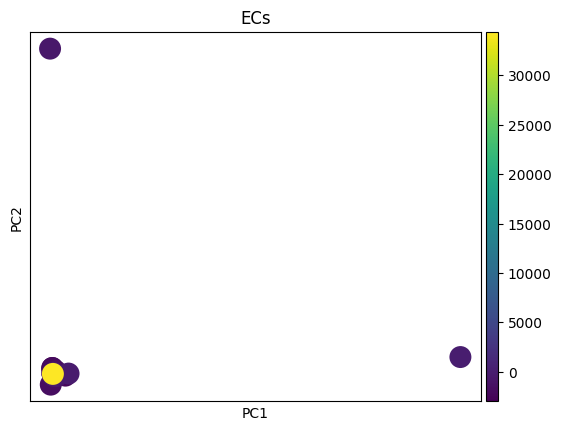

In [177]:
sc.pl.pca(adata, color="ECs", size=1e3)

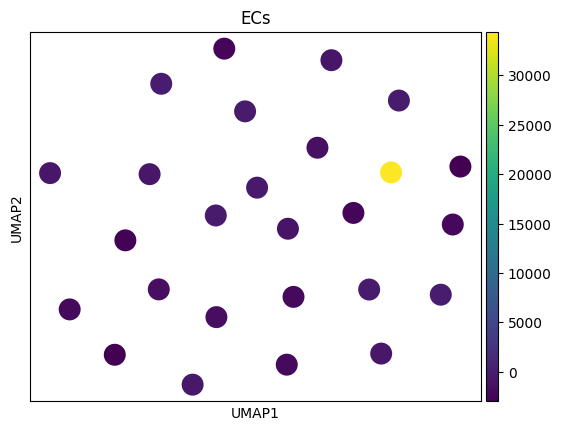

In [176]:
sc.pl.umap(adata, color="ECs", size=1e3)

In [89]:
def sort_and_score(adatatemp, marker_genes):
    marker_genes_in_data = {}
    for ct, markers in marker_genes.items():
        markers_found = []
        for marker in markers:
            if marker in adatatemp.var.index:
                markers_found.append(marker)
        if markers_found:
            marker_genes_in_data[ct] = markers_found

    for key in marker_genes_in_data.keys():
        sc.tl.score_genes(adatatemp, marker_genes_in_data[key], score_name=key)

    return adatatemp, marker_genes_in_data

In [91]:
import scanpy as sc

adata, marker_genes_in_data = sort_and_score(adata, cell_types_mouse_brain)

In [145]:
adata.obs.head()

,ECs,Pericytes,SMCs,Fibroblasts,Ependymal cells,Microglia_Macrophages,Oligodendrocytes,OPCs,Astrocytes,Neurons
nF25_d6_factors,,,,,,,,,,
0,-57.241013,-12.704545,-98.050000,1415.298701,-150.590909,94.313131,1.047400e+06,606.842880,-231103.275,-74783.217882
1,-565.433824,-2259.053030,-696.588462,-3212.194805,-434.784091,-1876.525253,-2.972745e+04,-4141.086180,-90630.950,346227.540799
2,-2493.455065,-2403.568182,-83.251923,9813.941558,750.329545,-1029.616162,2.791268e+05,23629.183395,-56418.975,-23303.511285
3,-1753.588235,-1521.712121,-790.086538,-1673.831169,-621.931818,-734.025253,-4.101154e+04,-6159.763531,-111344.600,199536.209201
4,-2930.515523,-4814.484848,-1596.534615,3109.649351,-1060.511364,-2289.808081,-1.322477e+04,7118.700998,157033.800,-16258.653646


In [18]:
# calculate ratio of mean marker gene expression within cluster / without cluster
log2fc = pd.DataFrame(
    index=cell_types_mouse_brain.keys(), columns=range(25), dtype=float
)
factors = range(25)
for factor in factors:
    remaining_factors = list(factors)
    remaining_factors.remove(factor)
    for ct, genes in cell_types_mouse_brain.items():
        mean_expr_ct = norm_factor_counts_df.loc[genes][factor].mean()
        mean_expr_rest = (
            norm_factor_counts_df.loc[genes][remaining_factors].mean().mean()
        )
        log2fc.loc[ct][factor] = np.log2(mean_expr_ct / mean_expr_rest)

display(log2fc)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
ECs,-5.374872,-0.508610,-3.377138,-3.831238,-4.181628,-2.251421,-3.083713,-3.337496,-3.110887,7.440596,...,-4.458678,-3.821231,-4.591896,-3.794646,-1.113503,-3.842700,-3.875199,-4.968181,-3.561462,-2.874991
Pericytes,-5.416588,-3.430628,-3.779062,-3.685513,-4.201198,-3.402517,-2.801024,-4.196766,-3.658232,4.306837,...,-3.592551,-3.254974,-3.831559,-3.585932,4.357502,-3.636422,-4.075699,-4.205533,-3.239569,-2.709699
SMCs,-4.821254,-1.753922,-0.911053,-2.377088,-3.196197,0.081008,-1.795553,-2.128600,-0.531333,1.659701,...,-3.671839,-2.046191,-3.603056,-2.673398,4.808069,-4.014332,-2.373127,-5.015269,-0.765297,-1.013082
Fibroblasts,-1.839864,-2.249176,1.954857,-2.944530,1.442151,-1.832780,-2.173876,-0.602015,-1.990348,-2.156101,...,-1.361899,-1.578342,0.574676,-0.305938,2.866091,0.686079,1.255170,-0.449495,-1.832913,-1.258298
Ependymal cells,-5.747068,-0.900950,-0.001089,-3.165340,-4.599138,-0.030447,-0.848337,-0.431429,-1.297042,-2.480052,...,-3.463522,-4.115488,-3.428891,-2.414190,5.251818,-4.301730,0.773583,-4.795940,-2.422977,-2.695415
Microglia_Macrophages,-5.502075,-3.515715,-3.534346,-3.613669,-4.643563,-3.505287,-2.977623,-3.082489,-3.344443,-3.967014,...,-4.126892,-3.581738,-4.103289,-3.724513,-3.102003,-4.478774,-3.945555,-4.426237,-3.832450,8.249148
Oligodendrocytes,3.883751,-3.756011,2.815670,-4.168394,-2.249581,-3.844098,-1.662067,-2.829518,-1.868350,-3.606891,...,-2.769321,-0.842250,-2.253667,-1.371545,-0.421440,-0.801636,-0.480617,-2.988142,-1.343077,-1.211559
OPCs,-3.241303,-3.153996,1.391424,-3.456801,0.247869,-3.145480,-3.514627,-2.251994,-3.091914,-3.015620,...,-2.306408,-1.587848,2.316729,-1.847409,-0.018792,-0.601105,-1.930870,-1.544197,4.442418,-2.430055
Astrocytes,-3.987978,-5.782986,-5.107791,-5.641512,2.588852,-5.375773,-5.270265,-3.951284,-4.559966,-1.621709,...,-2.432367,-1.429210,-0.907766,-1.345889,-1.555868,2.584360,3.781311,0.350739,-0.937947,-1.778319
Neurons,-6.125545,2.875978,-3.788553,1.762173,-4.177859,-0.638969,-0.455616,-0.824390,-1.820981,-5.296138,...,-1.476340,1.785171,-1.615369,-1.496870,-4.995519,-2.773563,-4.115438,2.346265,-2.927923,-3.337614


<Axes: >

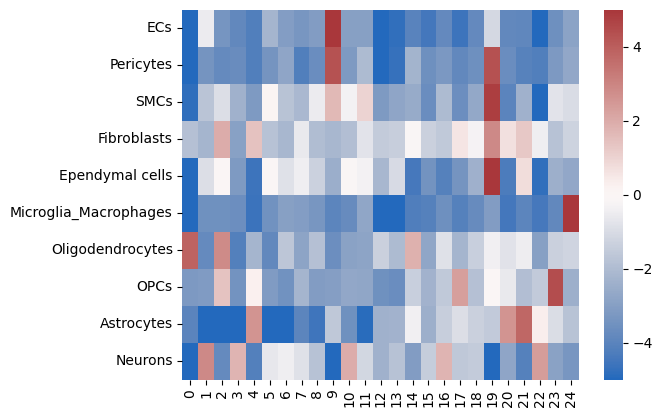

In [19]:
sns.heatmap(log2fc, cmap="vlag", vmin=-5, vmax=5)

## Most abundant genes for each factor
* normalised by factor size (description of factor)
* absolute counts (hint that factor might be specific to one gene only)

Text(0.5, 0.98, 'top 10 genes sorted by total transcript counts for each factor')

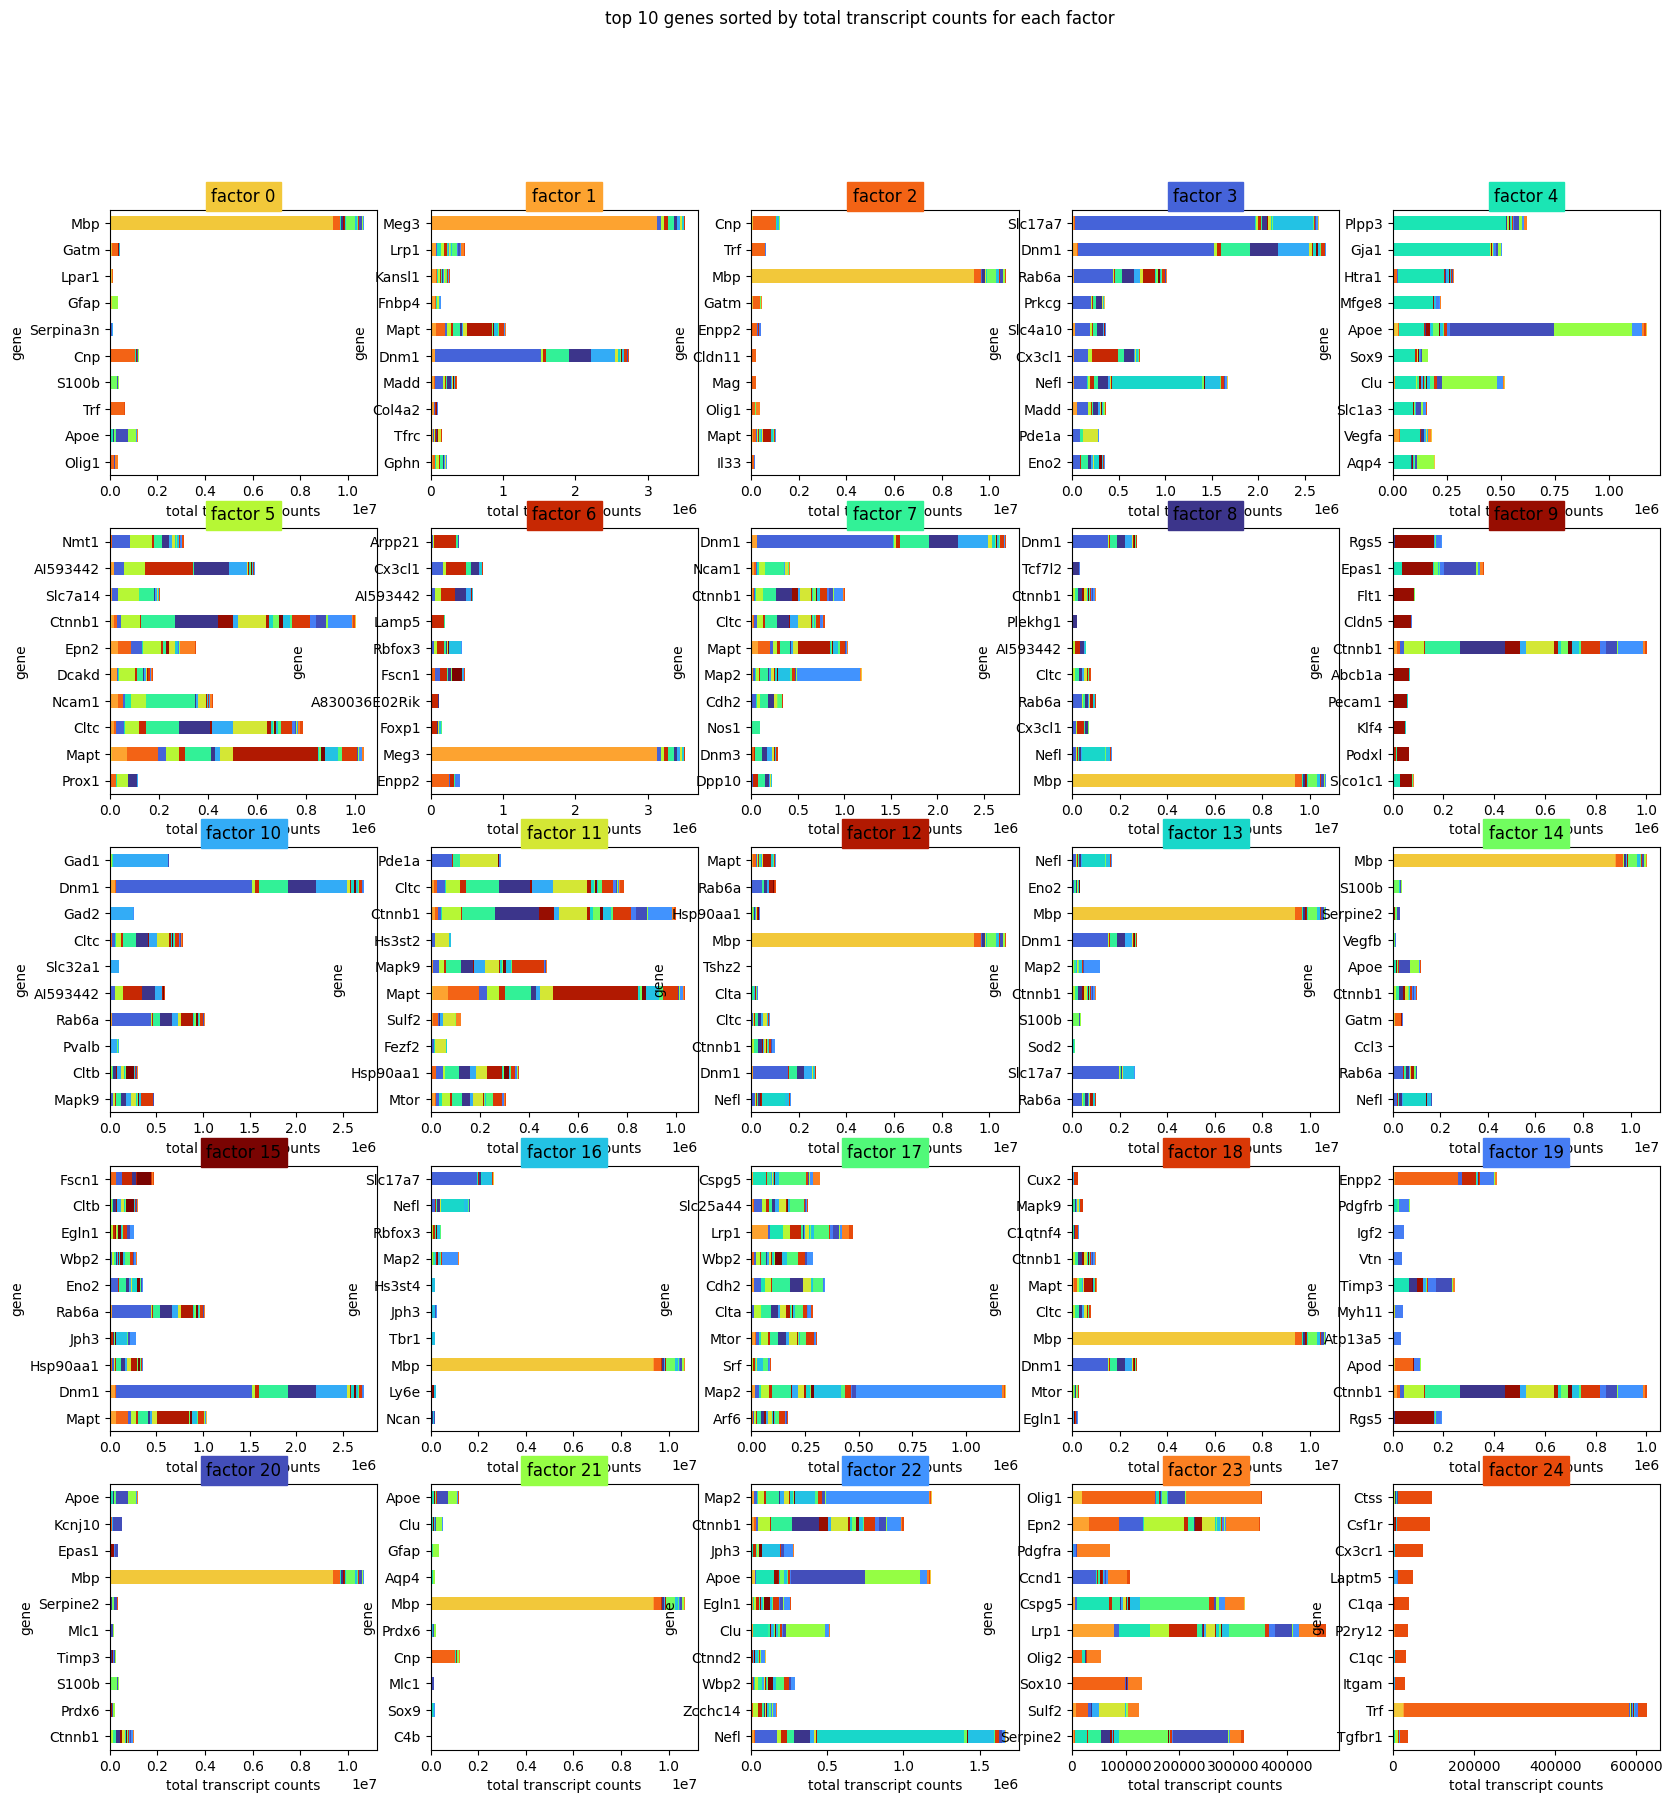

In [92]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
colors = [
    [float(c) / 255 for c in factor_color_code[factor].split(",")]
    for factor in range(25)
]
for factor, ax in enumerate(axes.flat):
    top_genes = factor_counts_df[factor].sort_values(ascending=False)[:10].index

    cur_counts = factor_counts_df.loc[top_genes]
    cur_counts.index = cur_counts.index.remove_unused_categories()

    ax = cur_counts.plot(kind="barh", stacked=True, ax=ax, legend=False, color=colors)
    ax.invert_yaxis()
    ax.set_xlabel("total transcript counts")
    ax.set_title(f"factor {factor}", backgroundcolor=colors[factor])

fig.suptitle("top 10 genes sorted by total transcript counts for each factor")

/home/hspitzer/miniconda3/envs/cellseg/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hspitzer/miniconda3/envs/cellseg/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hspitzer/miniconda3/envs/cellseg/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hspitzer/miniconda3/envs/cellseg/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/hspitzer/miniconda3/envs/cellseg/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, 

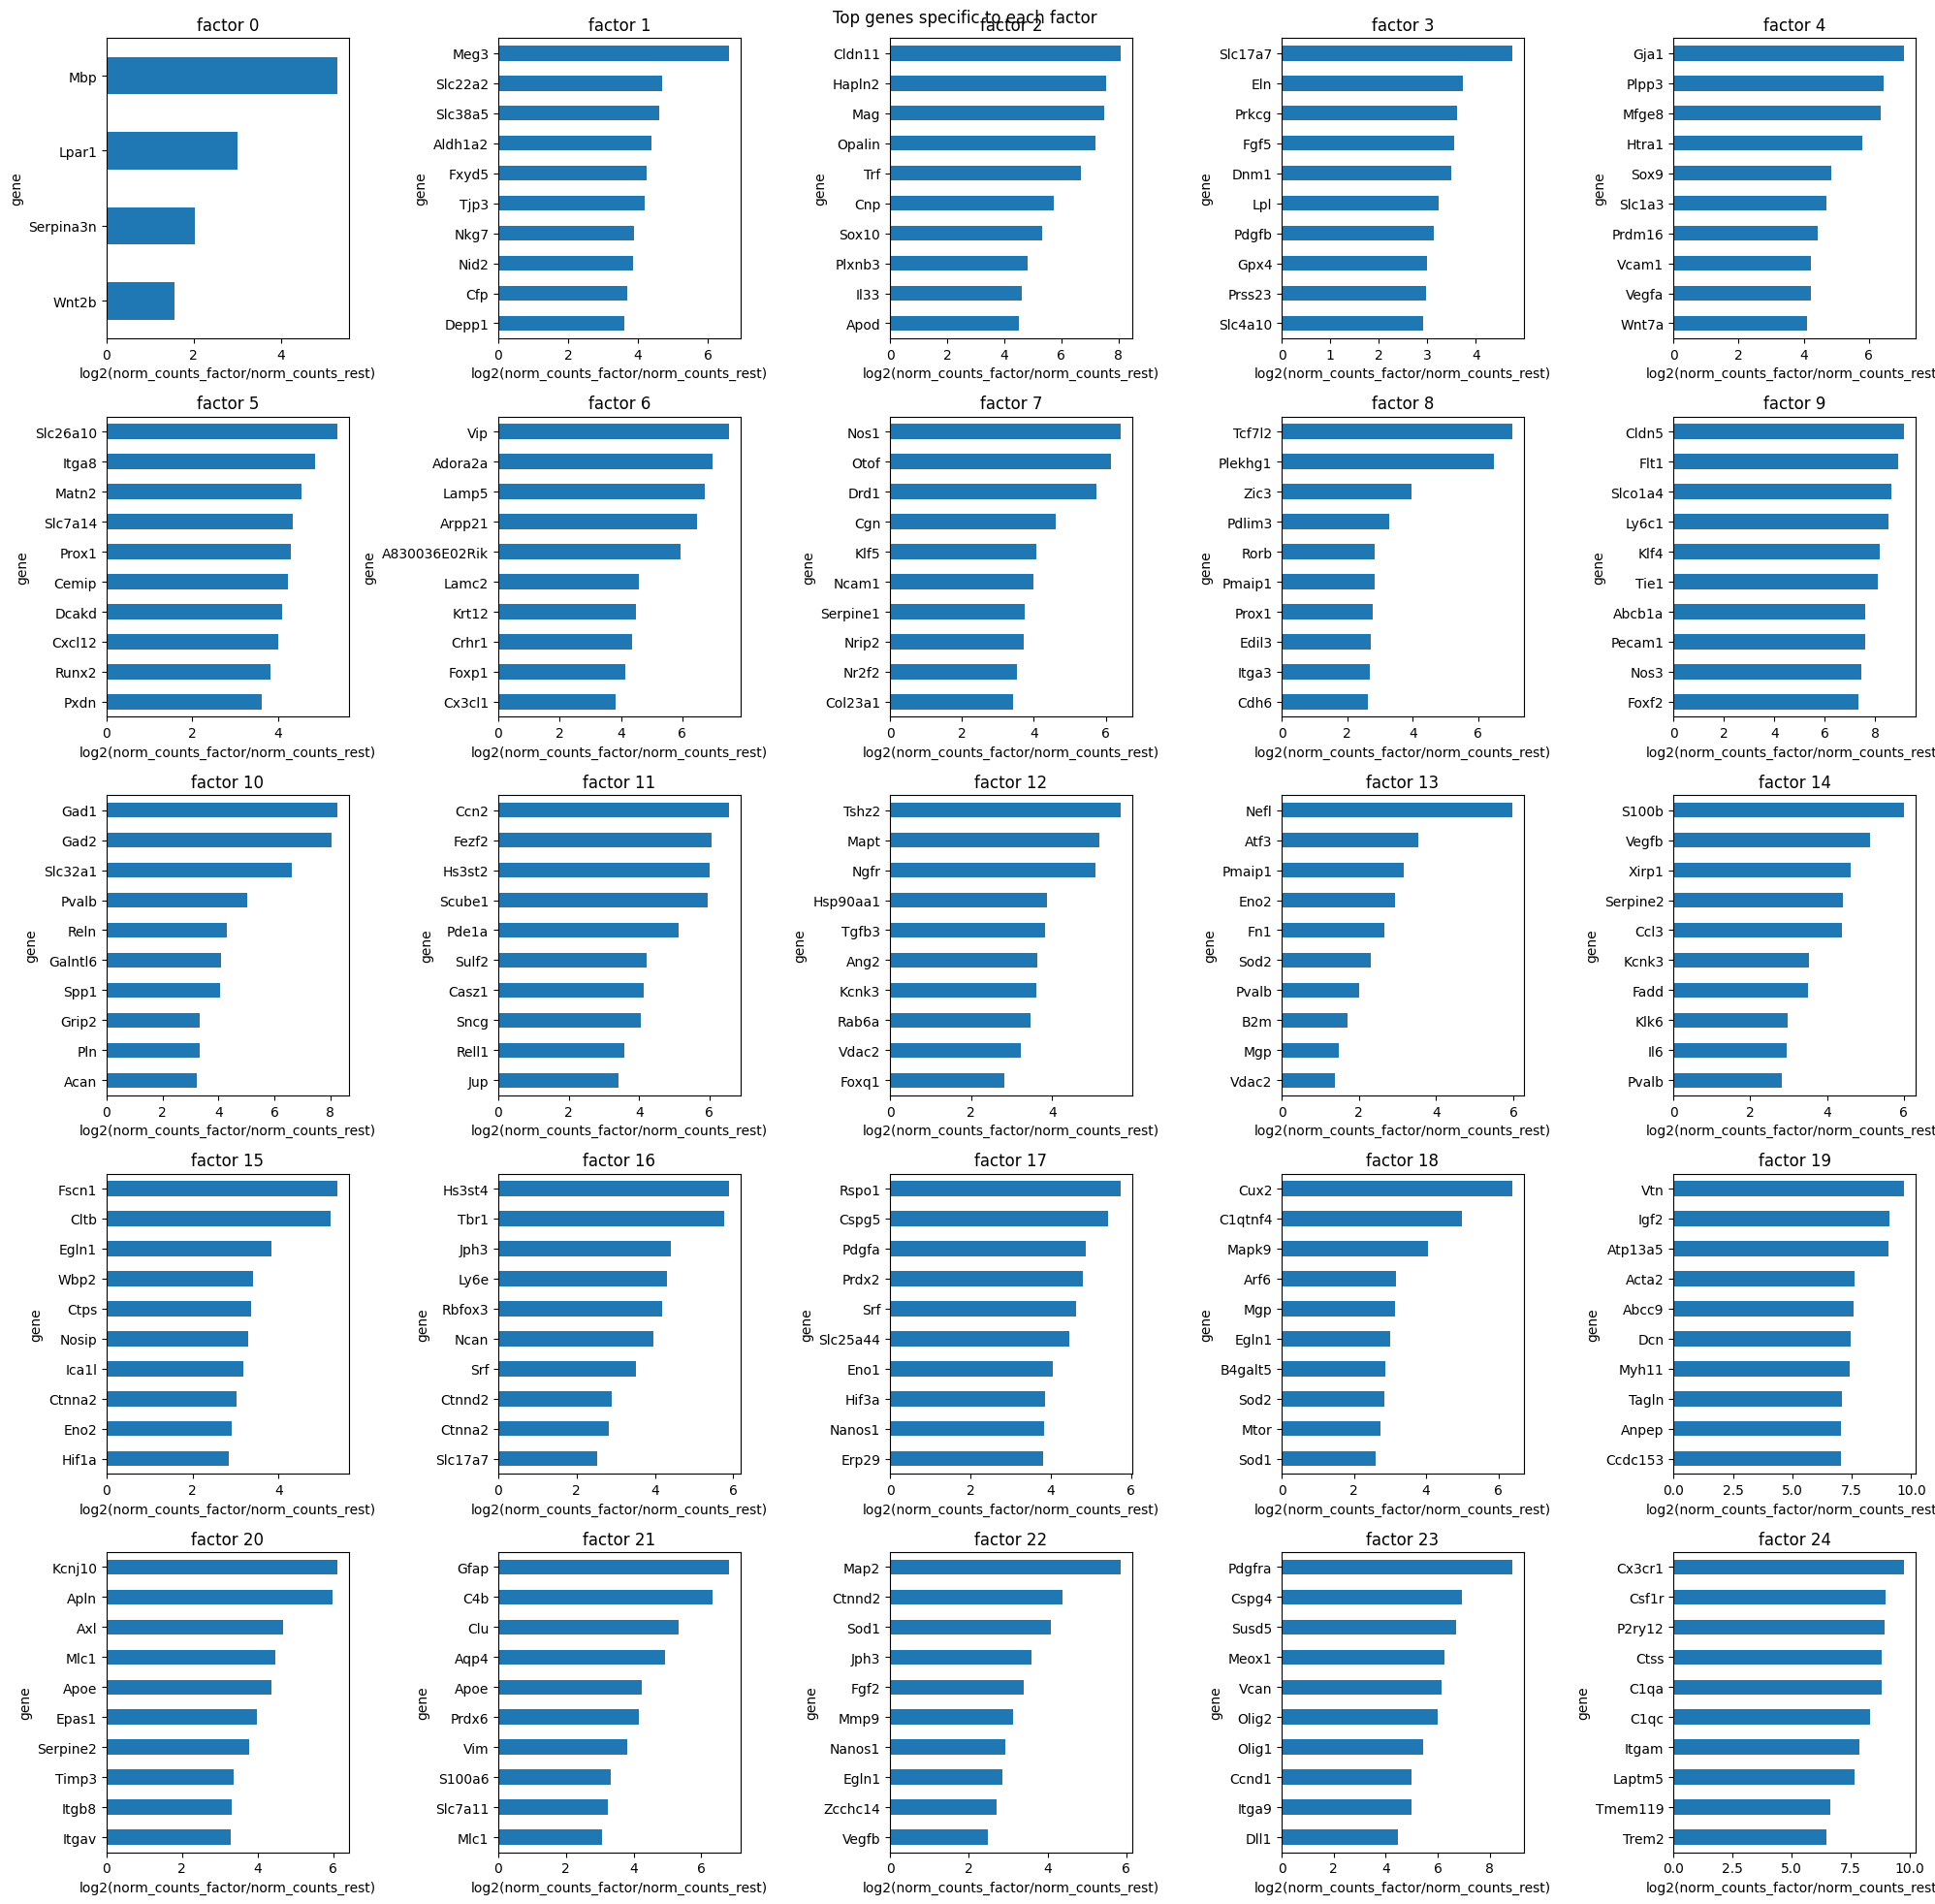

In [111]:
# normalise factor counts by factor size and get ratio of genes within cluster and outside of cluster
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
fig.suptitle("Top genes specific to each factor")
factors = range(25)
for factor, ax in zip(factors, axes.flat):
    norm_counts_cluster = factor_counts_df[factor] / factor_size[factor]
    remaining_factors = list(factors)
    remaining_factors.remove(factor)
    norm_counts_rest = (
        factor_counts_df[remaining_factors].sum(axis=1)
        / factor_size[remaining_factors].sum()
    )
    ratio = np.log2(norm_counts_cluster / norm_counts_rest)
    ratio = ratio.sort_values(ascending=False)
    # get all genes that are twice as prevalent inside cluster/factor than outside
    ratio = ratio[ratio > 1]
    # limit plot to top 10 genes
    ratio[:10].plot(kind="barh", ax=ax)
    ax.set_xlabel("log2(norm_counts_factor/norm_counts_rest)")
    ax.invert_yaxis()
    ax.set_title(f"factor {factor}")
plt.tight_layout()

## Calculate highly expressed genes
using transcripts only

In [26]:
gene_count = (
    sdata[f"{slide_name}_{region_name}_transcripts"]
    .groupby("gene")
    .count()["x"]
    .compute()
)

In [34]:
zscore(gene_count).sort_values(ascending=False).head(20)

gene
Mbp         20.020895
Meg3         6.422838
Dnm1         4.946575
Slc17a7      4.787223
Nefl         2.936109
Cnp          2.086999
Map2         2.013730
Apoe         2.002197
Mapt         1.736132
Rab6a        1.701284
Ctnnb1       1.669540
Cltc         1.263038
Cx3cl1       1.145624
Gad1         0.969538
Trf          0.956225
Plpp3        0.952695
AI593442     0.890806
Clu          0.752819
Kcnj10       0.738120
Gja1         0.728383
Name: x, dtype: float64

## Metric: Calculate percentage of transcripts outside vs inside cluster

In [112]:
def fraction_transcripts(
    sdata, points_name, cluster_column, cluster_list=None, gene_list=None
):
    """
    calculate fraction of transcripts within a cluster of interest.

    Args:
        sdata: spatial data object
        points_name: points element inside sdata containing transcripts
        cluster_column: column in sdata[points_name] to use as clustering
        cluster_list: (optional) list of clusters to calculate metric for. If None, all clusters are used.
        gene_list: (optional) list of genes to calculate metric for. If None, all genes are used.
            If a dictionary with gene_lists as values is passed, the function will return a dictionary containing resulting pd.DataFrames each gene_list in the values.

    Returns:
        pandas.DataFrame with gene_list as index, cluster_list as columns and entries the fraction of transcripts within the cluster.
    """
    points = sdata[points_name]

    # get default values
    if cluster_list is None:
        cluster_list = points[cluster_column].unique().compute()
    if gene_list is None:
        gene_list = points["gene"].unique().compute()

    if isinstance(gene_list, dict):
        res = {}
        for key, val in gene_list.items():
            res[key] = fraction_transcripts(
                sdata,
                points_name,
                cluster_column,
                cluster_list=cluster_list,
                gene_list=val,
            )
        return res

    else:
        grp = points.groupby(["gene", cluster_column]).count()["x"].compute()
        df = pd.DataFrame(index=gene_list, columns=cluster_list, dtype=float)
        # calculate score for each gene and cluster
        for gene in tqdm(gene_list):
            for cluster in cluster_list:
                cluster_count = grp.loc[(gene, cluster)]
                total_count = grp.loc[gene].sum()
                fraction = cluster_count / total_count
                df.loc[gene][cluster] = fraction
        return df

In [114]:
cluster_column = f"{ficture_name}_factors"
points_name = f"{slide_name}_{region_name}_transcripts"
# gene_list = ['Mbp', 'Aqp4', 'Cldn5', 'Nos3', 'Acta2', 'Myh11']
# cluster_list = [9, 19]

# calculate this for all known marker genes
res = fraction_transcripts(
    sdata, points_name, cluster_column, gene_list=cell_types_mouse_brain
)

  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_200358/1234805408.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[gene][cluster] = fraction
100%|██████████| 9/9 [00:00<00:00, 137.07it/s]


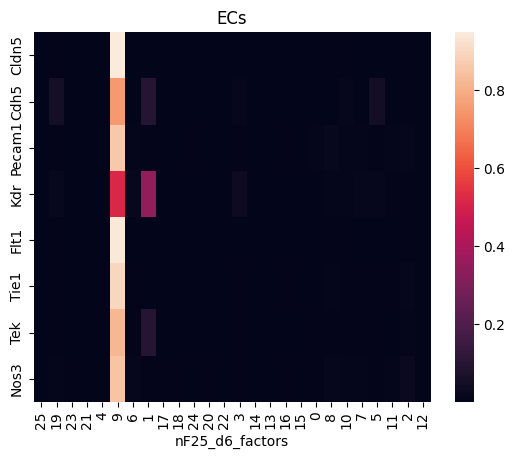

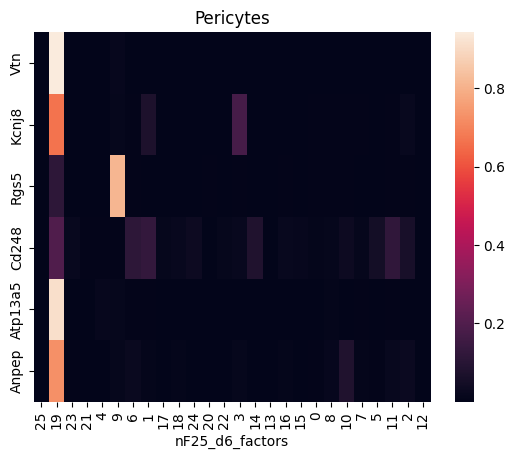

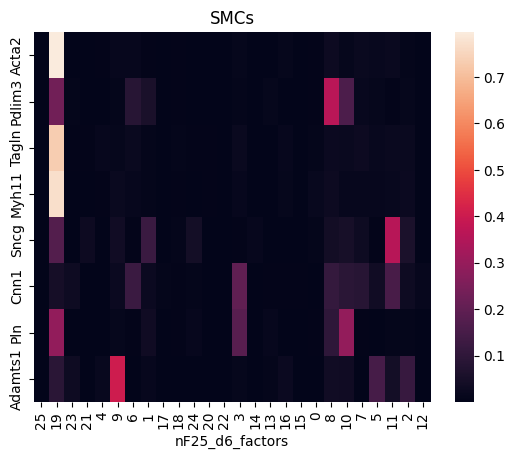

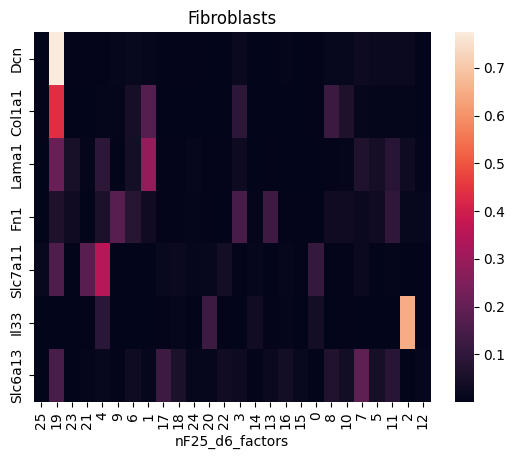

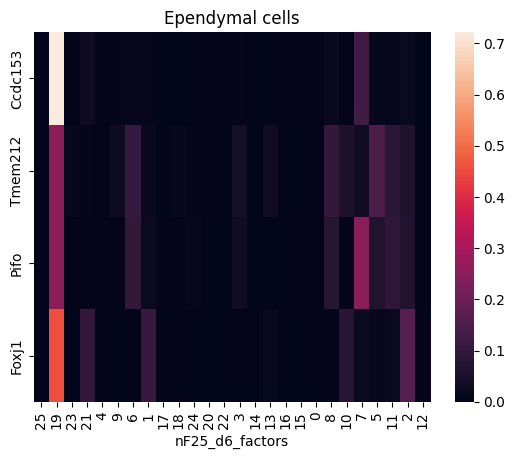

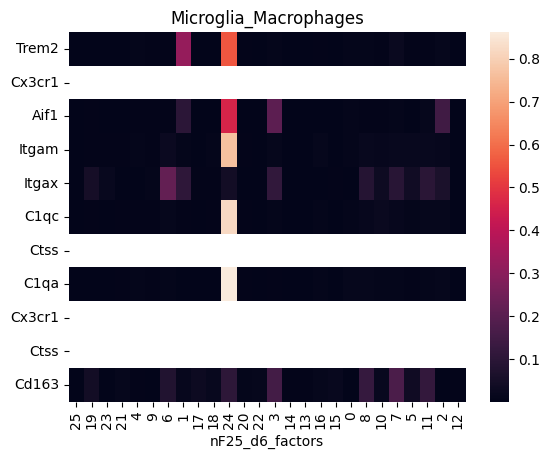

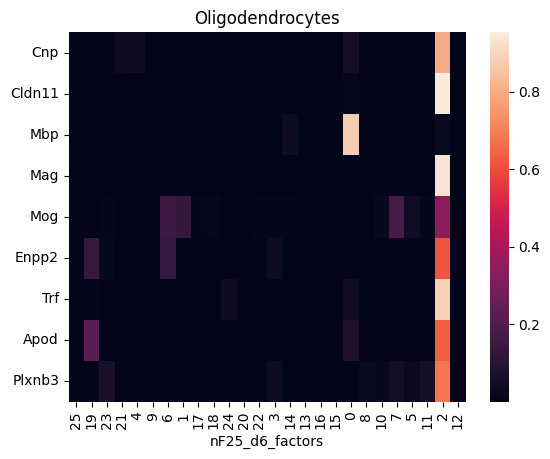

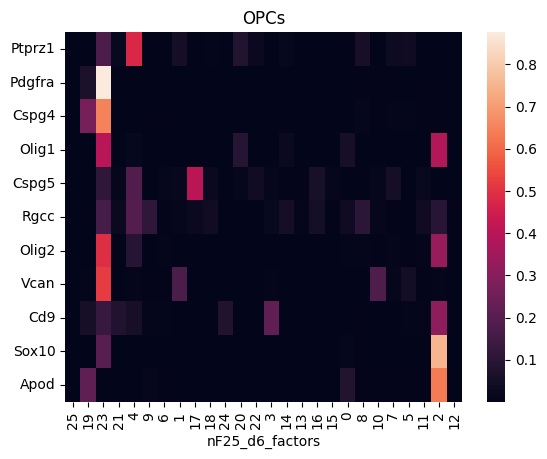

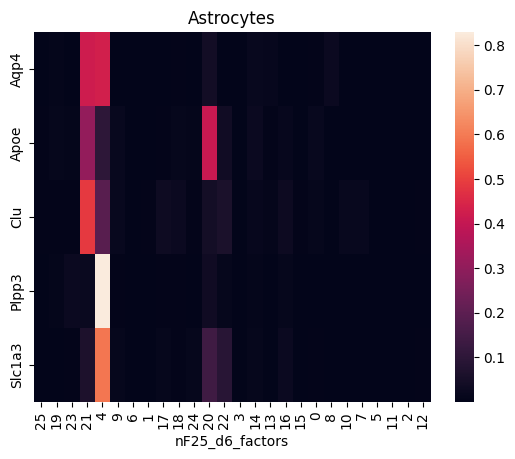

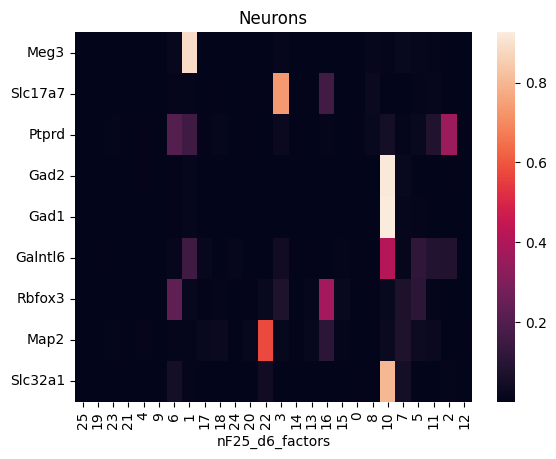

In [115]:
for key, df in res.items():
    fig = plt.figure()
    ax = sns.heatmap(df)
    ax.set_title(key)

In [ ]:
# mpb seems to have its own cluster - olygodendro + neurons/axons maybe?

## Metric: calculate distance of transcript to its cluster

In [8]:
pixel_name = f"{slide_name}_{region_name}_{ficture_name}_pixel_factors"
cluster_column_pixel = "K1"

points_name = f"{slide_name}_{region_name}_transcripts"
cluster_column_points = f"{ficture_name}_factors"

cluster = 2
gene = "Mbp"

# get pixel coordinates (in um)
df = sdata[pixel_name][sdata[pixel_name][cluster_column_pixel] == cluster][
    ["x", "y"]
].compute()

In [9]:
# set up KDTree for efficient querying
coords = np.array([df["x"], df["y"]]).T
tree = KDTree(
    coords, leafsize=10, compact_nodes=True, copy_data=False, balanced_tree=True
)

In [10]:
# get all transcripts of gene
points_gene = sdata[points_name].groupby(["gene"]).get_group(gene)
# select those that are outside of desired cluster (get coordinates for those in um)
points_gene = points_gene[points_gene[cluster_column_points] != cluster][
    ["x", "y"]
].compute()

In [11]:
# query kd tree to get nearest pixel
query = np.array([points_gene["x"], points_gene["y"]]).T
dd, ii = tree.query(query)

In [12]:
# dd contains the distances
dd

array([676.75751546, 542.06997953, 687.90182083, ..., 185.34503203,
       172.3456168 , 329.18665076])

<Axes: ylabel='Density'>

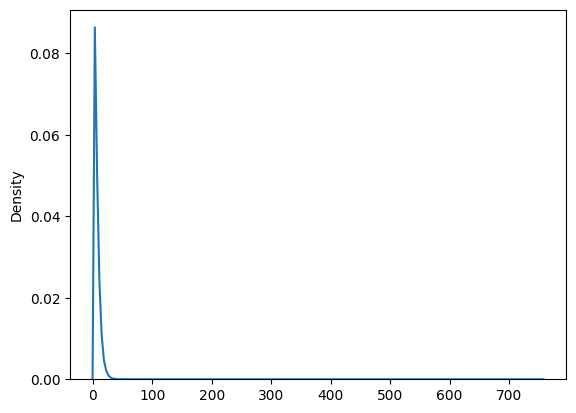

In [13]:
sns.kdeplot(dd)

<Axes: ylabel='Density'>

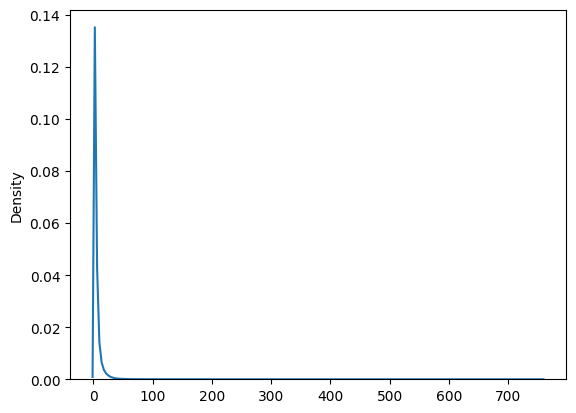

In [189]:
sns.kdeplot(dd)

## Visualisation of factors 

In [ ]:
sdata.pl.render

In [124]:
df = sdata["slide2_region1_transcripts_sample"].compute()

In [130]:
from spatialdata.transformations import (
    get_transformation,
)

In [131]:
print(sdata.coordinate_systems)
print(
    get_transformation(sdata["slide2_region1_nF25_d5_pixel_factors"]),
    get_transformation(sdata["slide2_region1_transcripts"]),
    get_transformation(sdata["slide2_region1_polygons"]),
)

['global']
Identity  Affine (x, y -> x, y)
    [    9.2593689      0.         -1484.83764648]
    [  0.           9.2594986  550.60424805]
    [0. 0. 1.] Affine (x, y -> x, y)
    [    9.2593689      0.         -1484.83764648]
    [  0.           9.2594986  550.60424805]
    [0. 0. 1.]


In [129]:
sdata

SpatialData object, with associated Zarr store: /home/hspitzer/projects/cellseg_benchmark/data/processed_data/FOXF2/SLIDE2/REGION1/sdata.zarr
├── Points
│     ├── 'slide2_region1_nF25_d5_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     ├── 'slide2_region1_nF25_d6_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     ├── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 11) (2D points)
│     └── 'slide2_region1_transcripts_sample': DataFrame with shape: (<Delayed>, 11) (2D points)
├── Shapes
│     └── 'slide2_region1_polygons': GeoDataFrame shape: (107013, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (107013, 500)
with coordinate systems:
    ▸ 'global', with elements:
        slide2_region1_nF25_d5_pixel_factors (Points), slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_transcripts_sample (Points), slide2_region1_polygons (Shapes)
with the following Dask-backed elements not 

In [128]:
df["x"].max()

6970.6406

In [133]:
sdata["slide2_region1_transcripts_sample"] = sdata.points[
    "slide2_region1_transcripts"
].sample(frac=0.001)

/home/hspitzer/miniconda3/envs/cellseg/lib/python3.12/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `slide2_region1_transcripts_sample` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [136]:
df = sdata["slide2_region1_transcripts_sample"].compute()

,x,y
2863,2085.30,561.10
2872,2085.19,561.39
2901,2085.09,562.29
3360,2058.09,570.10
3409,2057.90,570.29
...,...,...
92226375,6177.90,3061.10
92227256,6202.20,3080.80
92227257,6202.80,3080.80
92227270,6201.00,3081.19


In [139]:
sdata.pl.render_points?

Signature:
sdata.pl.render_points(
    element: 'str | None' = None,
    color: 'str | None' = None,
    alpha: 'float | int' = 1.0,
    groups: 'list[str] | str | None' = None,
    palette: 'list[str] | str | None' = None,
    na_color: 'ColorLike | None' = 'default',
    cmap: 'Colormap | str | None' = None,
    norm: 'Normalize | None' = None,
    size: 'float | int' = 1.0,
    method: 'str | None' = None,
    table_name: 'str | None' = None,
    **kwargs: 'Any',
) -> 'sd.SpatialData'
Docstring:
Render points elements in SpatialData.

In case of no elements specified, "broadcasting" of parameters is applied. This means that for any particular
SpatialElement, we validate whether a given parameter is valid. If not valid for a particular SpatialElement the
specific parameter for that particular SpatialElement will be ignored. If you want to set specific parameters
for specific elements please chain the render functions: `pl.render_points(...).pl.render_points(...).pl.show()`
.

Paramet

In [144]:
sdata["slide2_region1_transcripts_sample"]

,x,y,barcode_id,Unnamed: 0,cell_id,global_z,gene,fov,transcript_id,nF25_d5_factors,nF25_d6_factors
npartitions=96,,,,,,,,,,,
,float64,float64,int64,int64,int64,float64,category[unknown],int64,string,int64,int64
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [143]:
sdata.pl.render_points("slide2_region1_transcripts_sample", color="nF25_d6_factors")

SpatialData object
├── Points
│     ├── 'slide2_region1_nF25_d5_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     ├── 'slide2_region1_nF25_d6_pixel_factors': DataFrame with shape: (<Delayed>, 11) (2D points)
│     ├── 'slide2_region1_transcripts': DataFrame with shape: (<Delayed>, 11) (2D points)
│     └── 'slide2_region1_transcripts_sample': DataFrame with shape: (<Delayed>, 11) (2D points)
├── Shapes
│     └── 'slide2_region1_polygons': GeoDataFrame shape: (107013, 9) (2D shapes)
└── Tables
      └── 'table': AnnData (107013, 500)
with coordinate systems:
    ▸ 'global', with elements:
        slide2_region1_nF25_d5_pixel_factors (Points), slide2_region1_nF25_d6_pixel_factors (Points), slide2_region1_transcripts (Points), slide2_region1_transcripts_sample (Points), slide2_region1_polygons (Shapes)